In [1]:
!pip install pandas
!pip install scikit-learn 
!pip install openpyxl
!pip install matplotlib 
!pip install seaborn 
!pip install numpy 
!pip install statsmodels
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore")



Чтение и аналииз данных

In [2]:
train = pd.read_excel("train.xlsx")  
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                400 non-null    datetime64[ns]
 1   Цена на арматуру  400 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.4 KB


In [3]:
train.describe()

,dt,Цена на арматуру
count,400,400.000000
mean,2018-11-01 12:00:00,39229.475000
min,2015-01-05 00:00:00,21000.000000
25%,2016-12-03 06:00:00,31075.000000
50%,2018-11-01 12:00:00,35450.000000
75%,2020-09-29 18:00:00,42000.000000
max,2022-08-29 00:00:00,79000.000000
std,NaN,13407.979668


In [4]:
 # Преобразуем колонку с датой в формат datetime
train['dt'] = pd.to_datetime(train['dt'])

# Убеждаемся, что данные отсортированы по времени
train = train.sort_values(by='dt')


# Добавляем новые признаки
train["year"] = train["dt"].dt.year
train["month"] = train["dt"].dt.month
train["quarter"] = train["dt"].dt.quarter
train["day_of_month"] = train["dt"].dt.day
train["day_of_week"] = train["dt"].dt.weekday 

train = train.copy()


In [5]:
train.set_index('dt', inplace=True)

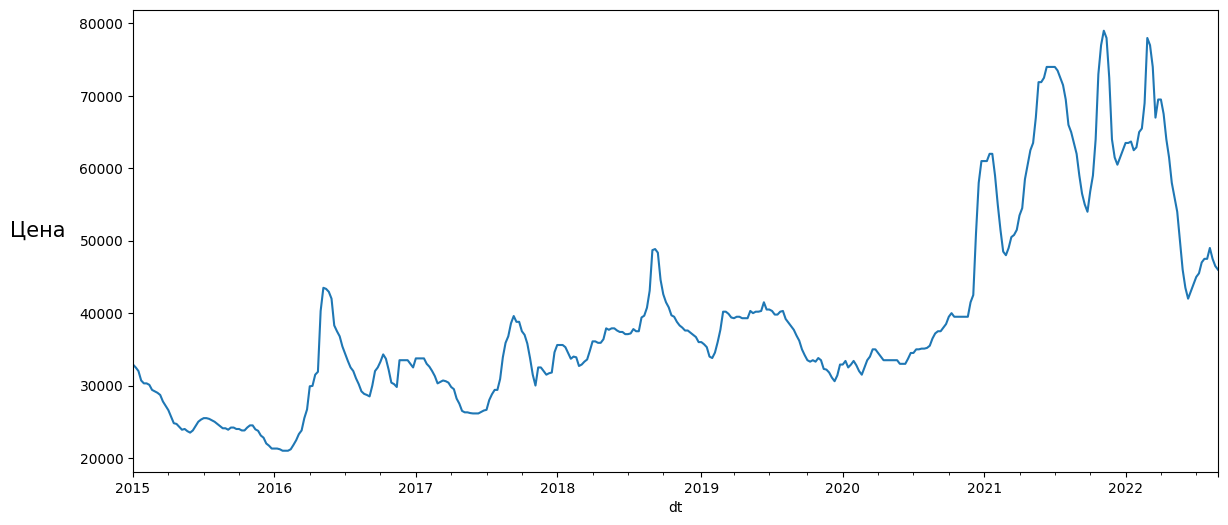

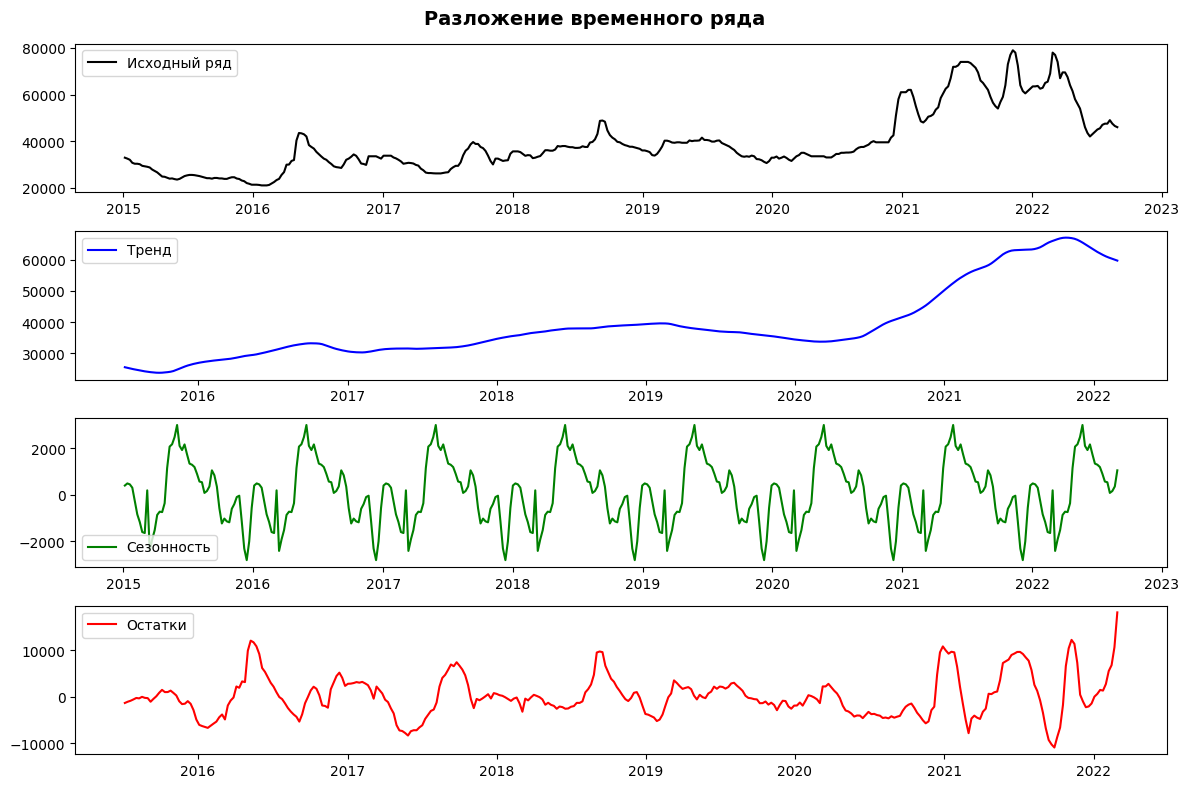

In [6]:
# Разложение временного ряда
decomposition = seasonal_decompose(train['Цена на арматуру'], model='additive', period=52)  # период ~1 год



# Рассмотрим изменение цены
plt.figure(figsize=(14, 6))
# plt.title('Time series example')
# plt.xlabel('Date', fontsize=15)
plt.ylabel('Цена', rotation=0, labelpad=30, fontsize=15)
train['Цена на арматуру'].plot()

plt.figure(figsize=(12, 8))
plt.suptitle("Разложение временного ряда", fontsize=14, fontweight='bold')

plt.subplot(4, 1, 1)
plt.plot(train['Цена на арматуру'], label='Исходный ряд', color='black')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Тренд', color='blue')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Сезонность', color='green')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Остатки', color='red')
plt.legend()

plt.tight_layout()
plt.show()

Проверка стационарности

In [7]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(series):
    """
    Функция для проверки стационарности временного ряда с помощью теста Дики-Фуллера.
    
   
    """
    result = adfuller(series.dropna())  # Тест ADF, удаляем NaN перед проверкой
    print("Результаты теста Дики-Фуллера:")
    print(f"ADF-статистика: {result[0]:.4f}")
    print(f"p-значение: {result[1]:.4f}")
    print("Критические значения:")
    for key, value in result[4].items():
        print(f"   {key}: {value:.4f}")
    
    # Интерпретация результатов
    if result[1] <= 0.05:
        print("\nРяд стационарен")
    else:
        print("\nРяд НЕ стационарен")

# Проверяем стационарность исходного ряда
test_stationarity(train['Цена на арматуру'])

Результаты теста Дики-Фуллера:
ADF-статистика: -1.9259
p-значение: 0.3200
Критические значения:
   1%: -3.4471
   5%: -2.8689
   10%: -2.5707

Ряд НЕ стационарен


Решение проблемы не стационарности

In [8]:
# Определяем окно скользящего стандартного отклонения
window = 12  # Например, 12 для месячных данных

# Копируем данные, чтобы не изменять оригинальный DataFrame
df_transformed = train.copy()

# Вычисляем скользящее стандартное отклонение
df_transformed['rolling_std'] = df_transformed['Цена на арматуру'].rolling(window=window).std()

# Нормализуем ряд, деля на скользящее стандартное отклонение
df_transformed['normalized_price'] = df_transformed['Цена на арматуру'] / df_transformed['rolling_std']

# Логарифмируем нормализованный ряд (добавляем небольшую константу, чтобы избежать log(0))
df_transformed['log_normalized_price'] = np.log(df_transformed['normalized_price'] + 1e-10)

# Дифференцируем логарифмированный ряд
df_transformed['stationary_price'] = df_transformed['log_normalized_price'].diff()

# Удаляем пропущенные значения, возникшие после вычислений
df_transformed = df_transformed.dropna()

# Выводим обработанный DataFrame
df_transformed


,Цена на арматуру,year,month,quarter,day_of_month,day_of_week,rolling_std,normalized_price,log_normalized_price,stationary_price
dt,,,,,,,,,,
2015-03-30,27200,2015,3,1,30,0,1556.413905,17.476071,2.860833,-0.012110
2015-04-06,26600,2015,4,2,6,0,1546.329966,17.202021,2.845027,-0.015806
2015-04-13,25700,2015,4,2,13,0,1605.388653,16.008585,2.773125,-0.071902
2015-04-20,24800,2015,4,2,20,0,1840.186914,13.476892,2.600977,-0.172149
2015-04-27,24700,2015,4,2,27,0,1980.109425,12.474058,2.523651,-0.077325
...,...,...,...,...,...,...,...,...,...,...
2022-08-01,47500,2022,8,3,1,0,3320.049288,14.307017,2.660750,0.271592
2022-08-08,49000,2022,8,3,8,0,2461.829820,19.903894,2.990915,0.330165
2022-08-15,47500,2022,8,3,15,0,2165.063509,21.939310,3.088280,0.097365


In [9]:
from scipy.stats import boxcox

df_stationary = df_transformed.copy()

df_stationary['boxcox_price'], lambda_bc = boxcox(df_transformed['Цена на арматуру'] + 1)

# Дифференцируем Box-Cox преобразованный ряд
df_stationary['diff_boxcox_price'] = df_stationary['boxcox_price'].diff()

df_stationary.dropna(inplace=True)

test_stationarity(df_stationary['diff_boxcox_price'])

df_stationary.to_csv("train_ready.csv", index=True)


Результаты теста Дики-Фуллера:
ADF-статистика: -7.3460
p-значение: 0.0000
Критические значения:
   1%: -3.4477
   5%: -2.8692
   10%: -2.5708

Ряд стационарен


In [10]:
train_ready = pd.read_csv("train_ready.csv")

In [11]:
target = train_ready['Цена на арматуру'].dropna()

target_diff = target.diff().dropna()

# Тест Дики-Фуллера после дифференцирования
adf_result = adfuller(target_diff)
adf_p_value = adf_result[1]

adf_p_value

np.float64(6.261499049431979e-14)

Модель SARIMA

MAE: 11449.07
MSE: 189904027.05
RMSE: 13780.57
R²: -0.8385


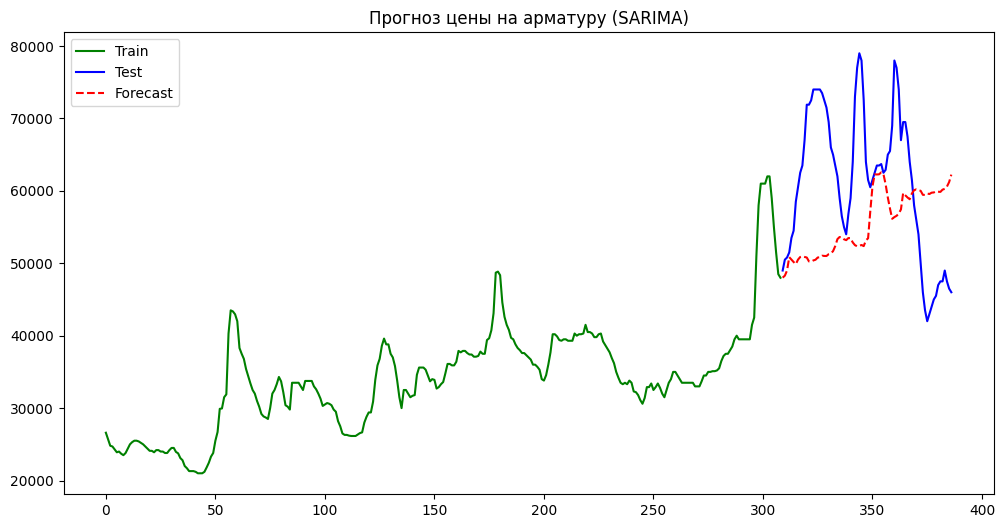

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Разложение на тренд и сезонность
decomposition = seasonal_decompose(train_ready['Цена на арматуру'], model='additive', period=52)
train_ready['trend'] = decomposition.trend
train_ready['seasonal'] = decomposition.seasonal

# Заполнение пропусков
for col in ['trend', 'seasonal']:
    train_ready[col] = train_ready[col].interpolate()

# Разделение данных на train и test
train_size = int(len(train_ready) * 0.8)
train_ready, test = train_ready.iloc[:train_size], train_ready.iloc[train_size:]

# Обучение модели SARIMA
model = SARIMAX(train_ready['Цена на арматуру'], order=(2,1,2), seasonal_order=(1,1,1,52))
model_fit = model.fit(disp=False)

# Прогнозирование
predictions = model_fit.predict(start=len(train_ready), end=len(train_ready) + len(test) - 1, dynamic=False)

# Оценка точности
mae = mean_absolute_error(test['Цена на арматуру'], predictions)
mse = mean_squared_error(test['Цена на арматуру'], predictions)
rmse = np.sqrt(mse)
r2 = r2_score(test['Цена на арматуру'], predictions)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(train_ready.index, train_ready['Цена на арматуру'], label='Train', color='green')
plt.plot(test.index, test['Цена на арматуру'], label='Test', color='blue')
plt.plot(test.index, predictions, label='Forecast', color='red', linestyle='--')
plt.title('Прогноз цены на арматуру (SARIMA)')
plt.legend()
plt.show()


In [13]:
!pip install lightgbm
!pip install optuna
import lightgbm as lgb
import optuna

Модель LightGBM №1

[I 2025-03-24 19:25:18,446] A new study created in memory with name: no-name-c3cb2ec4-bb6d-453c-b9e6-964f42e3252d
[I 2025-03-24 19:25:18,477] Trial 0 finished with value: 2240.712346130594 and parameters: {'learning_rate': 0.02765429547211791, 'num_leaves': 20, 'max_depth': 5, 'min_child_samples': 18, 'subsample': 0.9066777359374183, 'colsample_bytree': 0.8965298162275883}. Best is trial 0 with value: 2240.712346130594.
[I 2025-03-24 19:25:18,485] Trial 1 finished with value: 5391.758787674828 and parameters: {'learning_rate': 0.1929254537235549, 'num_leaves': 60, 'max_depth': 8, 'min_child_samples': 48, 'subsample': 0.8730293495242456, 'colsample_bytree': 0.6697821407404674}. Best is trial 0 with value: 2240.712346130594.
[I 2025-03-24 19:25:18,504] Trial 2 finished with value: 2186.5913491417496 and parameters: {'learning_rate': 0.04456580303031455, 'num_leaves': 12, 'max_depth': 7, 'min_child_samples': 16, 'subsample': 0.6912499315700418, 'colsample_bytree': 0.9953826386031176}. Bes

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[136]	valid_0's rmse: 2240.71
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	valid_0's rmse: 5391.76
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[77]	valid_0's rmse: 2186.59
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	valid_0's rmse: 5243.12
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	valid_0's rmse: 5463.97
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	valid_0's rmse: 4116.62
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	valid_0's rmse: 4451.94
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	valid_0's rmse: 3974.81

[I 2025-03-24 19:25:18,562] Trial 8 finished with value: 5015.827564362096 and parameters: {'learning_rate': 0.11449858551680865, 'num_leaves': 85, 'max_depth': 11, 'min_child_samples': 44, 'subsample': 0.736587269004898, 'colsample_bytree': 0.9256836432765381}. Best is trial 2 with value: 2186.5913491417496.
[I 2025-03-24 19:25:18,571] Trial 9 finished with value: 4333.944895220661 and parameters: {'learning_rate': 0.11766678576984171, 'num_leaves': 53, 'max_depth': 8, 'min_child_samples': 37, 'subsample': 0.9055844555570376, 'colsample_bytree': 0.6826830349623012}. Best is trial 2 with value: 2186.5913491417496.
[I 2025-03-24 19:25:18,640] Trial 10 finished with value: 2400.1286777628184 and parameters: {'learning_rate': 0.012919724593165566, 'num_leaves': 97, 'max_depth': 3, 'min_child_samples': 5, 'subsample': 0.5001196566387978, 'colsample_bytree': 0.5042850435246379}. Best is trial 2 with value: 2186.5913491417496.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[21]	valid_0's rmse: 4333.94
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[497]	valid_0's rmse: 2400.13


[I 2025-03-24 19:25:18,704] Trial 11 finished with value: 2222.098219570006 and parameters: {'learning_rate': 0.011203694052902932, 'num_leaves': 10, 'max_depth': 5, 'min_child_samples': 17, 'subsample': 0.973651160169303, 'colsample_bytree': 0.9976329964196595}. Best is trial 2 with value: 2186.5913491417496.
[I 2025-03-24 19:25:18,756] Trial 12 finished with value: 2134.8429655711543 and parameters: {'learning_rate': 0.05446248486304949, 'num_leaves': 10, 'max_depth': 4, 'min_child_samples': 17, 'subsample': 0.6486972966900594, 'colsample_bytree': 0.9817333518816923}. Best is trial 12 with value: 2134.8429655711543.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[338]	valid_0's rmse: 2222.1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[244]	valid_0's rmse: 2134.84


[I 2025-03-24 19:25:18,794] Trial 13 finished with value: 2189.0271148976285 and parameters: {'learning_rate': 0.057403509397991846, 'num_leaves': 38, 'max_depth': 3, 'min_child_samples': 18, 'subsample': 0.640318023984126, 'colsample_bytree': 0.9831835545508235}. Best is trial 12 with value: 2134.8429655711543.
[I 2025-03-24 19:25:18,845] Trial 14 finished with value: 1529.8905314964752 and parameters: {'learning_rate': 0.06173576952712571, 'num_leaves': 43, 'max_depth': 12, 'min_child_samples': 9, 'subsample': 0.6333169281765846, 'colsample_bytree': 0.8455554876050326}. Best is trial 14 with value: 1529.8905314964752.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[164]	valid_0's rmse: 2189.03
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[67]	valid_0's rmse: 1529.89


[I 2025-03-24 19:25:18,895] Trial 15 finished with value: 1725.92350112872 and parameters: {'learning_rate': 0.09359159898402687, 'num_leaves': 41, 'max_depth': 12, 'min_child_samples': 7, 'subsample': 0.5521814965694825, 'colsample_bytree': 0.8517145941987043}. Best is trial 14 with value: 1529.8905314964752.
[I 2025-03-24 19:25:18,952] Trial 16 finished with value: 1765.7588163524354 and parameters: {'learning_rate': 0.08608450093802306, 'num_leaves': 38, 'max_depth': 12, 'min_child_samples': 7, 'subsample': 0.5257652572980871, 'colsample_bytree': 0.8354670473016415}. Best is trial 14 with value: 1529.8905314964752.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	valid_0's rmse: 1725.92
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[55]	valid_0's rmse: 1765.76
Training until validation scores don't improve for 50 rounds


[I 2025-03-24 19:25:19,002] Trial 17 finished with value: 2282.0554350049347 and parameters: {'learning_rate': 0.07771372185025631, 'num_leaves': 45, 'max_depth': 12, 'min_child_samples': 11, 'subsample': 0.5685339008000376, 'colsample_bytree': 0.5739019088331296}. Best is trial 14 with value: 1529.8905314964752.
[I 2025-03-24 19:25:19,036] Trial 18 finished with value: 3317.040781409348 and parameters: {'learning_rate': 0.1436268686009875, 'num_leaves': 69, 'max_depth': 10, 'min_child_samples': 24, 'subsample': 0.5754771291169107, 'colsample_bytree': 0.8355734899818668}. Best is trial 14 with value: 1529.8905314964752.


Early stopping, best iteration is:
[64]	valid_0's rmse: 2282.06
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	valid_0's rmse: 3317.04
Training until validation scores don't improve for 50 rounds


[I 2025-03-24 19:25:19,075] Trial 19 finished with value: 1822.4931351430512 and parameters: {'learning_rate': 0.1333444017955812, 'num_leaves': 47, 'max_depth': 11, 'min_child_samples': 11, 'subsample': 0.5753024712587467, 'colsample_bytree': 0.7644462506685262}. Best is trial 14 with value: 1529.8905314964752.
[I 2025-03-24 19:25:19,106] Trial 20 finished with value: 3580.504482327919 and parameters: {'learning_rate': 0.07478796946481583, 'num_leaves': 70, 'max_depth': 11, 'min_child_samples': 25, 'subsample': 0.6708814617095142, 'colsample_bytree': 0.7023614025305748}. Best is trial 14 with value: 1529.8905314964752.
[I 2025-03-24 19:25:19,160] Trial 21 finished with value: 1588.664418752415 and parameters: {'learning_rate': 0.09550872394427115, 'num_leaves': 37, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.5074708661122389, 'colsample_bytree': 0.8331339233241679}. Best is trial 14 with value: 1529.8905314964752.


Early stopping, best iteration is:
[38]	valid_0's rmse: 1822.49
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	valid_0's rmse: 3580.5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[59]	valid_0's rmse: 1588.66
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[58]	valid_0's rmse: 1590.25


[I 2025-03-24 19:25:19,206] Trial 22 finished with value: 1590.2473193743333 and parameters: {'learning_rate': 0.09536630127801582, 'num_leaves': 32, 'max_depth': 12, 'min_child_samples': 10, 'subsample': 0.5369651805457382, 'colsample_bytree': 0.8617190000408957}. Best is trial 14 with value: 1529.8905314964752.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	valid_0's rmse: 1998.59


[I 2025-03-24 19:25:19,246] Trial 23 finished with value: 1998.5947858798368 and parameters: {'learning_rate': 0.1068334996829455, 'num_leaves': 28, 'max_depth': 10, 'min_child_samples': 11, 'subsample': 0.6087971243008754, 'colsample_bytree': 0.7996817268764937}. Best is trial 14 with value: 1529.8905314964752.
[I 2025-03-24 19:25:19,290] Trial 24 finished with value: 1714.9194075529558 and parameters: {'learning_rate': 0.0712436554606792, 'num_leaves': 33, 'max_depth': 12, 'min_child_samples': 13, 'subsample': 0.5116476356151666, 'colsample_bytree': 0.8993281751161273}. Best is trial 14 with value: 1529.8905314964752.
[I 2025-03-24 19:25:19,413] Trial 25 finished with value: 1553.115972976398 and parameters: {'learning_rate': 0.038511907122260554, 'num_leaves': 51, 'max_depth': 11, 'min_child_samples': 5, 'subsample': 0.6140588590958542, 'colsample_bytree': 0.8642402154516039}. Best is trial 14 with value: 1529.8905314964752.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[70]	valid_0's rmse: 1714.92
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[152]	valid_0's rmse: 1553.12
Training until validation scores don't improve for 50 rounds


[I 2025-03-24 19:25:19,524] Trial 26 finished with value: 1657.5404517940153 and parameters: {'learning_rate': 0.030593298192253333, 'num_leaves': 50, 'max_depth': 11, 'min_child_samples': 5, 'subsample': 0.6169447863359238, 'colsample_bytree': 0.9410010924973241}. Best is trial 14 with value: 1529.8905314964752.
[I 2025-03-24 19:25:19,610] Trial 27 finished with value: 1643.1083225911693 and parameters: {'learning_rate': 0.03955481180893805, 'num_leaves': 79, 'max_depth': 9, 'min_child_samples': 8, 'subsample': 0.6808189438114648, 'colsample_bytree': 0.7961845067446214}. Best is trial 14 with value: 1529.8905314964752.


Early stopping, best iteration is:
[147]	valid_0's rmse: 1657.54
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[162]	valid_0's rmse: 1643.11
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	valid_0's rmse: 3304.81


[I 2025-03-24 19:25:19,651] Trial 28 finished with value: 3304.81470167299 and parameters: {'learning_rate': 0.06805838915938485, 'num_leaves': 60, 'max_depth': 10, 'min_child_samples': 22, 'subsample': 0.5903498152902944, 'colsample_bytree': 0.7314150921960222}. Best is trial 14 with value: 1529.8905314964752.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[191]	valid_0's rmse: 1687.16


[I 2025-03-24 19:25:19,716] Trial 29 finished with value: 1687.1561385708726 and parameters: {'learning_rate': 0.026589897841398286, 'num_leaves': 43, 'max_depth': 9, 'min_child_samples': 14, 'subsample': 0.6353102845549891, 'colsample_bytree': 0.9033712321052422}. Best is trial 14 with value: 1529.8905314964752.
[I 2025-03-24 19:25:19,767] Trial 30 finished with value: 2440.528711884323 and parameters: {'learning_rate': 0.042439459781330346, 'num_leaves': 21, 'max_depth': 11, 'min_child_samples': 21, 'subsample': 0.739489944841444, 'colsample_bytree': 0.6419912858735546}. Best is trial 14 with value: 1529.8905314964752.
[I 2025-03-24 19:25:19,810] Trial 31 finished with value: 1574.5971610065196 and parameters: {'learning_rate': 0.09950456602342457, 'num_leaves': 35, 'max_depth': 12, 'min_child_samples': 9, 'subsample': 0.5466279901042157, 'colsample_bytree': 0.8506551245263745}. Best is trial 14 with value: 1529.8905314964752.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[157]	valid_0's rmse: 2440.53
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	valid_0's rmse: 1574.6
Training until validation scores don't improve for 50 rounds


[I 2025-03-24 19:25:19,868] Trial 32 finished with value: 1628.3436015145298 and parameters: {'learning_rate': 0.1203992248543362, 'num_leaves': 50, 'max_depth': 12, 'min_child_samples': 9, 'subsample': 0.5479869937379594, 'colsample_bytree': 0.8270793612144478}. Best is trial 14 with value: 1529.8905314964752.


Early stopping, best iteration is:
[42]	valid_0's rmse: 1628.34
Training until validation scores don't improve for 50 rounds


[I 2025-03-24 19:25:19,943] Trial 33 finished with value: 1676.392650313278 and parameters: {'learning_rate': 0.10232328760921167, 'num_leaves': 38, 'max_depth': 11, 'min_child_samples': 14, 'subsample': 0.5007028901154856, 'colsample_bytree': 0.8787732950115128}. Best is trial 14 with value: 1529.8905314964752.
[I 2025-03-24 19:25:19,992] Trial 34 finished with value: 1698.4218291042073 and parameters: {'learning_rate': 0.17764219879910187, 'num_leaves': 61, 'max_depth': 12, 'min_child_samples': 5, 'subsample': 0.5414134021852085, 'colsample_bytree': 0.9484172369598562}. Best is trial 14 with value: 1529.8905314964752.
[I 2025-03-24 19:25:20,039] Trial 35 finished with value: 1932.1300918813347 and parameters: {'learning_rate': 0.05958546791157716, 'num_leaves': 22, 'max_depth': 11, 'min_child_samples': 13, 'subsample': 0.6064007780902874, 'colsample_bytree': 0.7826976846352266}. Best is trial 14 with value: 1529.8905314964752.


Early stopping, best iteration is:
[47]	valid_0's rmse: 1676.39
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	valid_0's rmse: 1698.42
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[87]	valid_0's rmse: 1932.13
Training until validation scores don't improve for 50 rounds


[I 2025-03-24 19:25:20,096] Trial 36 finished with value: 1458.926584409029 and parameters: {'learning_rate': 0.08247503145086921, 'num_leaves': 57, 'max_depth': 10, 'min_child_samples': 8, 'subsample': 0.6587149195233837, 'colsample_bytree': 0.8562054923542064}. Best is trial 36 with value: 1458.926584409029.


Early stopping, best iteration is:
[76]	valid_0's rmse: 1458.93
Training until validation scores don't improve for 50 rounds


[I 2025-03-24 19:25:20,204] Trial 37 finished with value: 1461.0223620713691 and parameters: {'learning_rate': 0.0837575492368211, 'num_leaves': 56, 'max_depth': 10, 'min_child_samples': 8, 'subsample': 0.7031198464213453, 'colsample_bytree': 0.8639870017953238}. Best is trial 36 with value: 1458.926584409029.
[I 2025-03-24 19:25:20,255] Trial 38 finished with value: 2509.8957837075295 and parameters: {'learning_rate': 0.0503765830889906, 'num_leaves': 57, 'max_depth': 9, 'min_child_samples': 20, 'subsample': 0.7096817354521858, 'colsample_bytree': 0.9150095958311889}. Best is trial 36 with value: 1458.926584409029.


Early stopping, best iteration is:
[79]	valid_0's rmse: 1461.02
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[139]	valid_0's rmse: 2509.9
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	valid_0's rmse: 4115.11


[I 2025-03-24 19:25:20,288] Trial 39 finished with value: 4115.108532534586 and parameters: {'learning_rate': 0.08222152321047711, 'num_leaves': 74, 'max_depth': 10, 'min_child_samples': 37, 'subsample': 0.7080577872431298, 'colsample_bytree': 0.8704085907002134}. Best is trial 36 with value: 1458.926584409029.
[I 2025-03-24 19:25:20,343] Trial 40 finished with value: 1819.9042038841403 and parameters: {'learning_rate': 0.028025524052446082, 'num_leaves': 54, 'max_depth': 7, 'min_child_samples': 15, 'subsample': 0.7772154886481633, 'colsample_bytree': 0.7436198298282043}. Best is trial 36 with value: 1458.926584409029.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[162]	valid_0's rmse: 1819.9
Training until validation scores don't improve for 50 rounds


[I 2025-03-24 19:25:20,439] Trial 41 finished with value: 1385.0296409431733 and parameters: {'learning_rate': 0.06557731373931044, 'num_leaves': 48, 'max_depth': 10, 'min_child_samples': 8, 'subsample': 0.6548156707348083, 'colsample_bytree': 0.8915418280180218}. Best is trial 41 with value: 1385.0296409431733.


Early stopping, best iteration is:
[95]	valid_0's rmse: 1385.03
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[80]	valid_0's rmse: 1487.74


[I 2025-03-24 19:25:20,508] Trial 42 finished with value: 1487.736898256706 and parameters: {'learning_rate': 0.06608992167891212, 'num_leaves': 63, 'max_depth': 10, 'min_child_samples': 7, 'subsample': 0.6574669968647505, 'colsample_bytree': 0.9490427086338686}. Best is trial 41 with value: 1385.0296409431733.
[I 2025-03-24 19:25:20,569] Trial 43 finished with value: 1439.286735697097 and parameters: {'learning_rate': 0.06380043804639869, 'num_leaves': 59, 'max_depth': 8, 'min_child_samples': 8, 'subsample': 0.6660498083095463, 'colsample_bytree': 0.9571043292181675}. Best is trial 41 with value: 1385.0296409431733.
[I 2025-03-24 19:25:20,631] Trial 44 finished with value: 1622.5175101219236 and parameters: {'learning_rate': 0.08659477891340193, 'num_leaves': 66, 'max_depth': 8, 'min_child_samples': 12, 'subsample': 0.667194099471939, 'colsample_bytree': 0.9575491683008733}. Best is trial 41 with value: 1385.0296409431733.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[104]	valid_0's rmse: 1439.29
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	valid_0's rmse: 1622.52
Training until validation scores don't improve for 50 rounds


[I 2025-03-24 19:25:20,730] Trial 45 finished with value: 1481.635060275433 and parameters: {'learning_rate': 0.06948094325622883, 'num_leaves': 62, 'max_depth': 8, 'min_child_samples': 7, 'subsample': 0.8314946239034229, 'colsample_bytree': 0.9629007928756299}. Best is trial 41 with value: 1385.0296409431733.
[I 2025-03-24 19:25:20,776] Trial 46 finished with value: 2484.276313808018 and parameters: {'learning_rate': 0.05125389088730614, 'num_leaves': 58, 'max_depth': 8, 'min_child_samples': 19, 'subsample': 0.847370971383157, 'colsample_bytree': 0.9722324472973669}. Best is trial 41 with value: 1385.0296409431733.
[I 2025-03-24 19:25:20,829] Trial 47 finished with value: 1652.141239995279 and parameters: {'learning_rate': 0.07889853721838415, 'num_leaves': 76, 'max_depth': 6, 'min_child_samples': 15, 'subsample': 0.7568403162429913, 'colsample_bytree': 0.8903792994325586}. Best is trial 41 with value: 1385.0296409431733.


Early stopping, best iteration is:
[76]	valid_0's rmse: 1481.64
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[70]	valid_0's rmse: 2484.28
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	valid_0's rmse: 1652.14
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	valid_0's rmse: 5032.8


[I 2025-03-24 19:25:20,873] Trial 48 finished with value: 5032.804977438439 and parameters: {'learning_rate': 0.06585246146399529, 'num_leaves': 64, 'max_depth': 8, 'min_child_samples': 43, 'subsample': 0.8320514020298021, 'colsample_bytree': 0.9214626992766397}. Best is trial 41 with value: 1385.0296409431733.


Training until validation scores don't improve for 50 rounds

[I 2025-03-24 19:25:20,930] Trial 49 finished with value: 1508.2107660381553 and parameters: {'learning_rate': 0.11129664646575074, 'num_leaves': 85, 'max_depth': 6, 'min_child_samples': 7, 'subsample': 0.9040444449912881, 'colsample_bytree': 0.9721770021405718}. Best is trial 41 with value: 1385.0296409431733.



Early stopping, best iteration is:
[56]	valid_0's rmse: 1508.21
Лучшие параметры: {'learning_rate': 0.06557731373931044, 'num_leaves': 48, 'max_depth': 10, 'min_child_samples': 8, 'subsample': 0.6548156707348083, 'colsample_bytree': 0.8915418280180218}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[95]	valid_0's l2: 1.91831e+06
MAE: 1048.45
MSE: 1918307.11
RMSE: 1385.03
R²: 0.9828


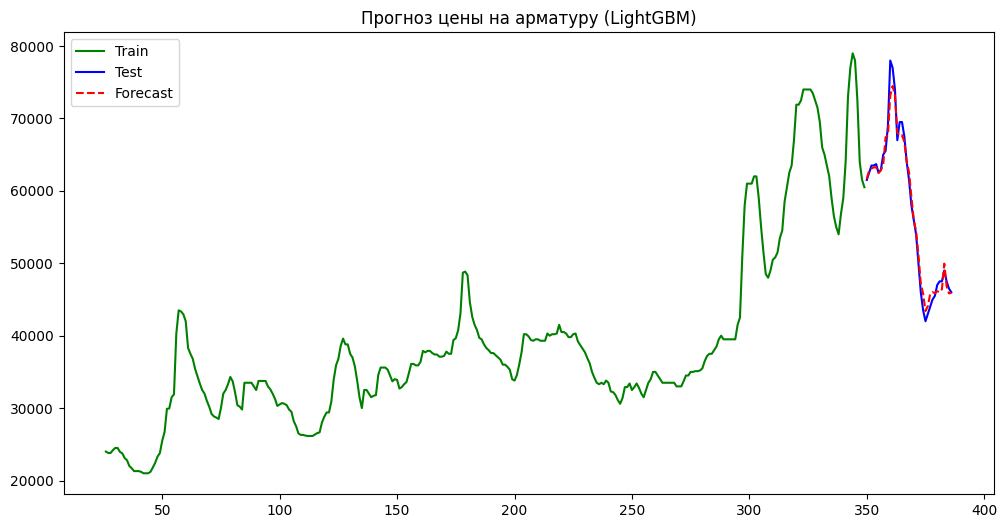

In [14]:
df = pd.read_csv("train_ready.csv", parse_dates=['dt'])

# Обработка стационарности (разложение на тренд и сезонность)
decomposition = seasonal_decompose(df['Цена на арматуру'], model='additive', period=52)
df['trend'] = decomposition.trend
df['seasonal'] = decomposition.seasonal

# Заполнение пропусков
df['trend'].interpolate(inplace=True)
df['seasonal'].interpolate(inplace=True)

# Количество временных лагов
lag_features = 12

for i in range(1, lag_features + 1):
    df[f"lag_{i}"] = df["Цена на арматуру"].shift(i)

df.dropna(inplace=True)  # Убираем пропущенные значения

# Выбираем целевую переменную и признаки
target_col = "Цена на арматуру"
feature_cols = [col for col in df.columns if col not in ["dt", target_col]]

# Разделяем данные на train/test
train_size = 0.9
train_df, test_df = train_test_split(df, test_size=1-train_size, shuffle=False)

X_train, y_train = train_df[feature_cols], train_df[target_col]
X_test, y_test = test_df[feature_cols], test_df[target_col]

# Создаём датасеты для LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.2),
        'num_leaves': trial.suggest_int("num_leaves", 10, 100),
        'max_depth': trial.suggest_int("max_depth", 3, 12),
        'min_child_samples': trial.suggest_int("min_child_samples", 5, 50),
        'subsample': trial.suggest_float("subsample", 0.5, 1.0),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.5, 1.0),
        'feature_pre_filter': False,
        'verbose': -1
    }

    model = lgb.train(params, train_data, num_boost_round=500, valid_sets=[test_data],
                      callbacks=[lgb.early_stopping(50)])

    preds = model.predict(X_test)
    return np.sqrt(mean_squared_error(y_test, preds))

# Запуск Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Лучшие параметры
best_params = study.best_params
print("Лучшие параметры:", best_params)

# Обучение финальной модели
best_params["verbose"] = -1
final_model = lgb.train(best_params, train_data, num_boost_round=500, valid_sets=[test_data],
                        callbacks=[lgb.early_stopping(50)])

# Прогноз
final_predictions = final_model.predict(X_test)

# Оценка точности
mae = mean_absolute_error(y_test, final_predictions)
mse = mean_squared_error(y_test, final_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, final_predictions)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(train_df.index, y_train, label='Train', color='green')
plt.plot(test_df.index, y_test, label='Test', color='blue')
plt.plot(test_df.index, final_predictions, label='Forecast', color='red', linestyle='--')
plt.title('Прогноз цены на арматуру (LightGBM)')
plt.legend()
plt.show()


Добавление фичей

In [15]:
df['rolling_mean_3'] = df["Цена на арматуру"].rolling(window=3).mean()
df['rolling_mean_6'] = df["Цена на арматуру"].rolling(window=6).mean()
df['rolling_mean_12'] = df["Цена на арматуру"].rolling(window=12).mean()

df['price_diff_1'] = df["Цена на арматуру"].diff(1)
df['price_diff_3'] = df["Цена на арматуру"].diff(3)

df['ewm_6'] = df["Цена на арматуру"].ewm(span=6, adjust=False).mean()
df['ewm_12'] = df["Цена на арматуру"].ewm(span=12, adjust=False).mean()

df.fillna(0, inplace=True)

print(df.head())

           dt  Цена на арматуру  year  month  quarter  day_of_month  \
26 2015-10-05             24000  2015     10        4             5   
27 2015-10-12             23800  2015     10        4            12   
28 2015-10-19             23800  2015     10        4            19   
29 2015-10-26             24200  2015     10        4            26   
30 2015-11-02             24500  2015     11        4             2   

    day_of_week  rolling_std  normalized_price  log_normalized_price  ...  \
26            0   514.045158         46.688505              3.843498  ...   
27            0   443.129368         53.708921              3.983579  ...   
28            0   361.394605         65.855991              4.187470  ...   
29            0   255.247948         94.809773              4.551872  ...   
30            0   217.422923        112.683611              4.724584  ...   

     lag_10   lag_11   lag_12  rolling_mean_3  rolling_mean_6  \
26  25200.0  25400.0  25500.0        0.000000

In [16]:
features = [
    "rolling_mean_3", "rolling_mean_6", "rolling_mean_12",
    "price_diff_1", "price_diff_3", "ewm_6", "ewm_12"
]

target = "Цена на арматуру"

X = df[features]
y = df[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)


(288, 7) (73, 7)
(288,) (73,)


Матрица корреляции

In [22]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# corr_matrix = df.corr()
# plt.figure(figsize=(20, 10))
# sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
# plt.title("Корреляция признаков")
# plt.show()


Модель LightGBM №2

[I 2025-03-24 19:25:22,130] A new study created in memory with name: no-name-22a5475f-7093-4c9a-a149-a60a4eda3346
[I 2025-03-24 19:25:22,154] Trial 0 finished with value: 3184.201660321398 and parameters: {'learning_rate': 0.10096459807550916, 'num_leaves': 57, 'max_depth': 3, 'min_child_samples': 22, 'subsample': 0.7923307944938198, 'colsample_bytree': 0.6673451850973389}. Best is trial 0 with value: 3184.201660321398.
[I 2025-03-24 19:25:22,185] Trial 1 finished with value: 1731.5406513899045 and parameters: {'learning_rate': 0.09344343761664026, 'num_leaves': 77, 'max_depth': 12, 'min_child_samples': 8, 'subsample': 0.6930969359419213, 'colsample_bytree': 0.5461461493556012}. Best is trial 1 with value: 1731.5406513899045.
[I 2025-03-24 19:25:22,198] Trial 2 finished with value: 4017.521286886464 and parameters: {'learning_rate': 0.062239215981597845, 'num_leaves': 80, 'max_depth': 11, 'min_child_samples': 34, 'subsample': 0.8479670861578892, 'colsample_bytree': 0.6816636838605908}.

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's rmse: 3184.2
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	valid_0's rmse: 1731.54
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	valid_0's rmse: 4017.52
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[76]	valid_0's rmse: 4328.23
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	valid_0's rmse: 1551.03
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[197]	valid_0's rmse: 1705.43
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[123]	valid_0's rmse: 5855.19
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	valid_0's rmse: 1554.4


[I 2025-03-24 19:25:22,369] Trial 8 finished with value: 1474.2784392181732 and parameters: {'learning_rate': 0.043088778196952345, 'num_leaves': 67, 'max_depth': 11, 'min_child_samples': 5, 'subsample': 0.5552545805249951, 'colsample_bytree': 0.7122290081989127}. Best is trial 8 with value: 1474.2784392181732.
[I 2025-03-24 19:25:22,405] Trial 9 finished with value: 1679.8140020919752 and parameters: {'learning_rate': 0.09751238166241719, 'num_leaves': 87, 'max_depth': 12, 'min_child_samples': 6, 'subsample': 0.7372619039516533, 'colsample_bytree': 0.6809840668076231}. Best is trial 8 with value: 1474.2784392181732.
[I 2025-03-24 19:25:22,441] Trial 10 finished with value: 2457.661338173109 and parameters: {'learning_rate': 0.15504759870432885, 'num_leaves': 12, 'max_depth': 9, 'min_child_samples': 21, 'subsample': 0.9684392383957035, 'colsample_bytree': 0.8780521550789014}. Best is trial 8 with value: 1474.2784392181732.
[I 2025-03-24 19:25:22,485] Trial 11 finished with value: 2054.

Early stopping, best iteration is:
[140]	valid_0's rmse: 1474.28
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	valid_0's rmse: 1679.81
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	valid_0's rmse: 2457.66
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[101]	valid_0's rmse: 2054.22
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's rmse: 1445.32
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[89]	valid_0's rmse: 1787.66


[I 2025-03-24 19:25:22,596] Trial 14 finished with value: 3530.308803729253 and parameters: {'learning_rate': 0.13620489491948348, 'num_leaves': 37, 'max_depth': 5, 'min_child_samples': 27, 'subsample': 0.6345868678846728, 'colsample_bytree': 0.8887768753724223}. Best is trial 12 with value: 1445.3238923690512.
[I 2025-03-24 19:25:22,658] Trial 15 finished with value: 1662.4809229110042 and parameters: {'learning_rate': 0.05053395909013188, 'num_leaves': 70, 'max_depth': 10, 'min_child_samples': 14, 'subsample': 0.5461469851496683, 'colsample_bytree': 0.7401152296548523}. Best is trial 12 with value: 1445.3238923690512.
[I 2025-03-24 19:25:22,692] Trial 16 finished with value: 3631.539166229792 and parameters: {'learning_rate': 0.12681802820997506, 'num_leaves': 65, 'max_depth': 8, 'min_child_samples': 27, 'subsample': 0.6608833940588233, 'colsample_bytree': 0.8532663593102466}. Best is trial 12 with value: 1445.3238923690512.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	valid_0's rmse: 3530.31
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[95]	valid_0's rmse: 1662.48
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 3631.54
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[212]	valid_0's rmse: 1618.94


[I 2025-03-24 19:25:22,777] Trial 17 finished with value: 1618.9449842290717 and parameters: {'learning_rate': 0.05652541244981566, 'num_leaves': 40, 'max_depth': 7, 'min_child_samples': 5, 'subsample': 0.7171502828590626, 'colsample_bytree': 0.952953723834305}. Best is trial 12 with value: 1445.3238923690512.
[I 2025-03-24 19:25:22,807] Trial 18 finished with value: 3351.6189503379182 and parameters: {'learning_rate': 0.16712928795723783, 'num_leaves': 37, 'max_depth': 5, 'min_child_samples': 22, 'subsample': 0.5634148046894571, 'colsample_bytree': 0.752789244510035}. Best is trial 12 with value: 1445.3238923690512.
[I 2025-03-24 19:25:22,848] Trial 19 finished with value: 1626.3482949525464 and parameters: {'learning_rate': 0.1216079599076042, 'num_leaves': 98, 'max_depth': 11, 'min_child_samples': 13, 'subsample': 0.8124863216051534, 'colsample_bytree': 0.598912505322339}. Best is trial 12 with value: 1445.3238923690512.
[I 2025-03-24 19:25:22,891] Trial 20 finished with value: 3943

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	valid_0's rmse: 3351.62
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	valid_0's rmse: 1626.35
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[65]	valid_0's rmse: 3943.14
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	valid_0's rmse: 1706.15
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[68]	valid_0's rmse: 1681.81
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's rmse: 2205.72


[I 2025-03-24 19:25:23,011] Trial 23 finished with value: 2205.7161931265955 and parameters: {'learning_rate': 0.15328261973798335, 'num_leaves': 59, 'max_depth': 6, 'min_child_samples': 17, 'subsample': 0.6754418802899762, 'colsample_bytree': 0.9278658191220228}. Best is trial 12 with value: 1445.3238923690512.
[I 2025-03-24 19:25:23,049] Trial 24 finished with value: 1631.781702163282 and parameters: {'learning_rate': 0.07557161481320632, 'num_leaves': 71, 'max_depth': 4, 'min_child_samples': 10, 'subsample': 0.5006038731533144, 'colsample_bytree': 0.5608329738106491}. Best is trial 12 with value: 1445.3238923690512.
[I 2025-03-24 19:25:23,084] Trial 25 finished with value: 2284.5248556443194 and parameters: {'learning_rate': 0.11882762013712748, 'num_leaves': 44, 'max_depth': 5, 'min_child_samples': 19, 'subsample': 0.5506155124893197, 'colsample_bytree': 0.6421138909757929}. Best is trial 12 with value: 1445.3238923690512.
[I 2025-03-24 19:25:23,117] Trial 26 finished with value: 1

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[82]	valid_0's rmse: 1631.78
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	valid_0's rmse: 2284.52
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	valid_0's rmse: 1935.31
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	valid_0's rmse: 1663.63
Training until validation scores don't improve for 50 rounds


[I 2025-03-24 19:25:23,248] Trial 28 finished with value: 3512.35087989077 and parameters: {'learning_rate': 0.01378167896509578, 'num_leaves': 54, 'max_depth': 7, 'min_child_samples': 25, 'subsample': 0.6259810379306142, 'colsample_bytree': 0.8337966038084204}. Best is trial 12 with value: 1445.3238923690512.
[I 2025-03-24 19:25:23,285] Trial 29 finished with value: 1436.7731701517898 and parameters: {'learning_rate': 0.10982477559939728, 'num_leaves': 58, 'max_depth': 3, 'min_child_samples': 9, 'subsample': 0.9760939669135937, 'colsample_bytree': 0.7836481546624383}. Best is trial 29 with value: 1436.7731701517898.
[I 2025-03-24 19:25:23,336] Trial 30 finished with value: 1772.7655503070496 and parameters: {'learning_rate': 0.10885974104005193, 'num_leaves': 70, 'max_depth': 10, 'min_child_samples': 16, 'subsample': 0.9616122702199863, 'colsample_bytree': 0.7844340529720487}. Best is trial 29 with value: 1436.7731701517898.
[I 2025-03-24 19:25:23,371] Trial 31 finished with value: 13

Early stopping, best iteration is:
[178]	valid_0's rmse: 3512.35
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	valid_0's rmse: 1436.77
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[102]	valid_0's rmse: 1772.77
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	valid_0's rmse: 1386.39
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[183]	valid_0's rmse: 1482.57


[I 2025-03-24 19:25:23,436] Trial 32 finished with value: 1482.566129573142 and parameters: {'learning_rate': 0.06937126223178136, 'num_leaves': 62, 'max_depth': 4, 'min_child_samples': 5, 'subsample': 0.9417698195896208, 'colsample_bytree': 0.7910574191420076}. Best is trial 31 with value: 1386.3906205311234.
[I 2025-03-24 19:25:23,479] Trial 33 finished with value: 1321.9042447904583 and parameters: {'learning_rate': 0.11181547832871923, 'num_leaves': 57, 'max_depth': 3, 'min_child_samples': 7, 'subsample': 0.999225910556346, 'colsample_bytree': 0.7213125681926124}. Best is trial 33 with value: 1321.9042447904583.
[I 2025-03-24 19:25:23,514] Trial 34 finished with value: 1383.0971591304074 and parameters: {'learning_rate': 0.10812768004242358, 'num_leaves': 56, 'max_depth': 3, 'min_child_samples': 8, 'subsample': 0.9984439567811885, 'colsample_bytree': 0.7642504790553991}. Best is trial 33 with value: 1321.9042447904583.
[I 2025-03-24 19:25:23,549] Trial 35 finished with value: 4327.

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	valid_0's rmse: 1321.9
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	valid_0's rmse: 1383.1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[86]	valid_0's rmse: 4327.49
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[79]	valid_0's rmse: 1371.47
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[62]	valid_0's rmse: 1514.49
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	valid_0's rmse: 1446.43


[I 2025-03-24 19:25:23,664] Trial 38 finished with value: 1446.425592899695 and parameters: {'learning_rate': 0.0987573524692467, 'num_leaves': 77, 'max_depth': 3, 'min_child_samples': 7, 'subsample': 0.8968530489392588, 'colsample_bytree': 0.7231382142937235}. Best is trial 33 with value: 1321.9042447904583.
[I 2025-03-24 19:25:23,719] Trial 39 finished with value: 1550.0308714745722 and parameters: {'learning_rate': 0.07096617033003033, 'num_leaves': 53, 'max_depth': 4, 'min_child_samples': 11, 'subsample': 0.8579364389941175, 'colsample_bytree': 0.6690333377800056}. Best is trial 33 with value: 1321.9042447904583.
[I 2025-03-24 19:25:23,769] Trial 40 finished with value: 5763.677229800776 and parameters: {'learning_rate': 0.07932318852559235, 'num_leaves': 85, 'max_depth': 5, 'min_child_samples': 50, 'subsample': 0.9992928204090309, 'colsample_bytree': 0.690399978250721}. Best is trial 33 with value: 1321.9042447904583.
[I 2025-03-24 19:25:23,806] Trial 41 finished with value: 1382.

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[77]	valid_0's rmse: 1550.03
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	valid_0's rmse: 5763.68
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[61]	valid_0's rmse: 1382.29
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[53]	valid_0's rmse: 1374.63
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[71]	valid_0's rmse: 1441.82


[I 2025-03-24 19:25:23,882] Trial 43 finished with value: 1441.8151584482696 and parameters: {'learning_rate': 0.0915434297366817, 'num_leaves': 44, 'max_depth': 4, 'min_child_samples': 7, 'subsample': 0.7945096099036603, 'colsample_bytree': 0.7130555544448772}. Best is trial 33 with value: 1321.9042447904583.
[I 2025-03-24 19:25:23,917] Trial 44 finished with value: 1395.9709353933802 and parameters: {'learning_rate': 0.11894798582014605, 'num_leaves': 51, 'max_depth': 3, 'min_child_samples': 8, 'subsample': 0.9035223611303518, 'colsample_bytree': 0.7417027541349365}. Best is trial 33 with value: 1321.9042447904583.
[I 2025-03-24 19:25:23,949] Trial 45 finished with value: 5090.013089645261 and parameters: {'learning_rate': 0.12878184014531846, 'num_leaves': 45, 'max_depth': 3, 'min_child_samples': 47, 'subsample': 0.8556294942551358, 'colsample_bytree': 0.692680500700862}. Best is trial 33 with value: 1321.9042447904583.
[I 2025-03-24 19:25:23,987] Trial 46 finished with value: 1483.

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	valid_0's rmse: 1395.97
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	valid_0's rmse: 5090.01
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[56]	valid_0's rmse: 1483.46
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[78]	valid_0's rmse: 2390.15
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[85]	valid_0's rmse: 1369.16
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[93]	valid_0's rmse: 1701.43
Лучшие параметры: {'learning_rate': 0.11181547832871923, 'num_leaves': 57, 'max_depth': 3, 'min_child_samples': 7, 'subsample': 0.999225910556346, 'colsample_bytree': 0.7213125681926124}
Training until validation scores don't improve for 50 rounds
Ea

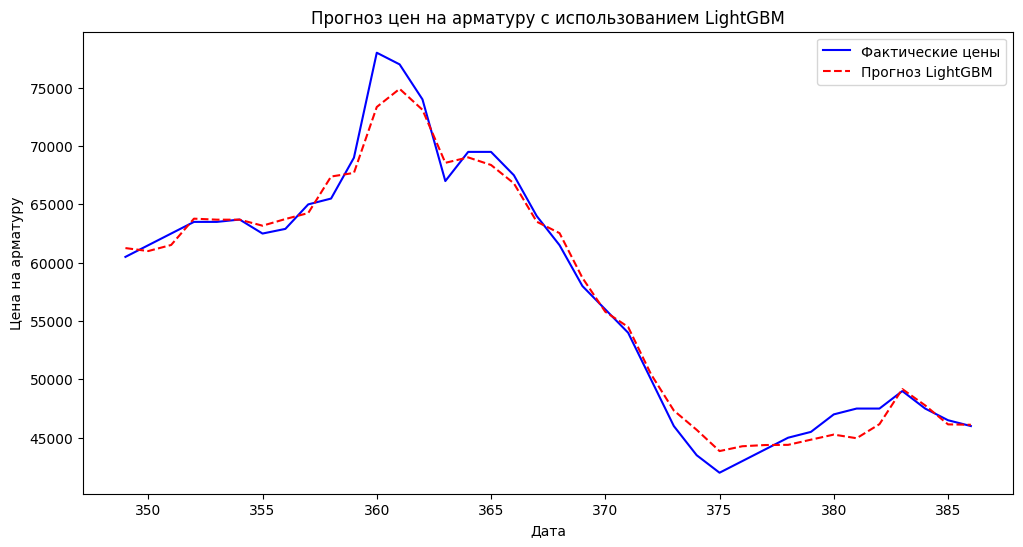

In [18]:
df = pd.read_csv("train_ready.csv", parse_dates=['dt'])

# Количество временных лагов
lag_features = 12
for i in range(1, lag_features + 1):
    df[f"lag_{i}"] = df["Цена на арматуру"].shift(i)

# Добавляем скользящие средние
df["rolling_mean_3"] = df["Цена на арматуру"].rolling(3).mean()
df["rolling_mean_6"] = df["Цена на арматуру"].rolling(6).mean()
df["rolling_mean_12"] = df["Цена на арматуру"].rolling(12).mean()

# Добавляем экспоненциальное сглаживание
df["ewm_6"] = df["Цена на арматуру"].ewm(span=6).mean()
df["ewm_12"] = df["Цена на арматуру"].ewm(span=12).mean()

# Добавляем разности цен
df["diff_1"] = df["Цена на арматуру"].diff(1)
df["diff_3"] = df["Цена на арматуру"].diff(3)

df = df.dropna()  

# Выбираем целевую переменную и признаки
target_col = "Цена на арматуру"
feature_cols = [col for col in df.columns if col not in ["dt", target_col]]

# Разделяем данные на train/test
train_size = 0.9  # 90% данных на обучение
train_df, test_df = train_test_split(df, test_size=1-train_size, shuffle=False)

X_train, y_train = train_df[feature_cols], train_df[target_col]
X_test, y_test = test_df[feature_cols], test_df[target_col]

# Создаём датасеты для LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.2),
        'num_leaves': trial.suggest_int("num_leaves", 10, 100),
        'max_depth': trial.suggest_int("max_depth", 3, 12),
        'min_child_samples': trial.suggest_int("min_child_samples", 5, 50),
        'subsample': trial.suggest_float("subsample", 0.5, 1.0),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.5, 1.0),
        'feature_pre_filter': False,
        'verbose': -1
    }

    model = lgb.train(params, train_data, num_boost_round=500, valid_sets=[test_data],
                      callbacks=[lgb.early_stopping(50)])
    
    preds = model.predict(X_test)
    return np.sqrt(mean_squared_error(y_test, preds))

# Запуск Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Лучшие параметры
best_params = study.best_params
print("Лучшие параметры:", best_params)

# Обучение финальной модели с лучшими параметрами
best_params["verbose"] = -1
final_model = lgb.train(best_params, train_data, num_boost_round=500, valid_sets=[test_data],
                        callbacks=[lgb.early_stopping(50)])

# Прогнозируем
final_predictions = final_model.predict(X_test)

# Оценка точности
mae = mean_absolute_error(y_test, final_predictions)
mse = mean_squared_error(y_test, final_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, final_predictions)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

# Визуализация прогнозов
plt.figure(figsize=(12, 6))
plt.plot(test_df.index, y_test, label='Фактические цены', color='blue')
plt.plot(test_df.index, final_predictions, label='Прогноз LightGBM', color='red', linestyle='--')
plt.xlabel("Дата")
plt.ylabel("Цена на арматуру")
plt.title("Прогноз цен на арматуру с использованием LightGBM")
plt.legend()
plt.show()

In [ ]:
mape = np.mean(np.abs((y_test - final_predictions) / y_test)) * 100

accuracy = 100 - mape

print(f"MAPE: {mape:.2f}%")
print(f"Точность модели: {accuracy:.2f}%")


MAPE: 1.76%
Точность модели: 98.24%


In [ ]:
import pickle

model_filename = "lightgbm_model.pkl"
with open(model_filename, "wb") as file:
    pickle.dump(final_model, file)

print(f"Модель сохранена в {model_filename}")


Модель сохранена в lightgbm_model.pkl
